# Santiago De Chile Delays

Let's import all the tools we need for our data explaration

In [247]:
# !pip install --upgrade pip --user
!pip install -r ../requirements.txt --user

ERROR: Invalid requirement: '<<<<<<< HEAD' (from line 1 of ../requirements.txt)


In [248]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Step 1: Reviewing the Dataset
Let's first go over the provided data and see what valuable insights we can find.

We begin by loading the dataframe with pandas library and viewing the it's head.

In [249]:
df = pd.read_csv('../data/dataset_SCL.csv')
df.head(20)

C:\Users\kevin\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3433: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami
5,2017-01-06 23:30:00,226,SCEL,KMIA,AAL,2017-01-07 00:04:00,226,SCEL,KMIA,AAL,7,1,2017,Sabado,I,American Airlines,Santiago,Miami
6,2017-01-07 23:30:00,226,SCEL,KMIA,AAL,2017-01-07 23:25:00,226,SCEL,KMIA,AAL,7,1,2017,Sabado,I,American Airlines,Santiago,Miami
7,2017-01-08 23:30:00,226,SCEL,KMIA,AAL,2017-01-08 23:25:00,226,SCEL,KMIA,AAL,8,1,2017,Domingo,I,American Airlines,Santiago,Miami
8,2017-01-09 23:30:00,226,SCEL,KMIA,AAL,2017-01-10 00:10:00,226,SCEL,KMIA,AAL,10,1,2017,Martes,I,American Airlines,Santiago,Miami
9,2017-01-11 23:30:00,226,SCEL,KMIA,AAL,2017-01-12 00:39:00,226,SCEL,KMIA,AAL,12,1,2017,Jueves,I,American Airlines,Santiago,Miami


For a better understanding of the different labels below are the information for each column:

* **Fecha-I :** Scheduled date and time of the flight.
* **Vlo-I :** Scheduled flight number.
* **Ori-I :** Programmed origin city code.
* **Des-I :** Programmed destination city code.
* **Emp-I :** Scheduled flight airline code.
* **Fecha-O :** Date and time of flight operation.
* **Vlo-O :** Flight operation number of the flight.
* **Ori-O :** Operation origin city code
* **Des-O :** Operation destination city code.
* **Emp-O :** Airline code of the operated flight.
* **DIA:** Day of the month of flight operation.
* **MES :** Number of the month of operation of the flight.
* **AÑO :** Year of flight operation.
* **DIANOM :** Day of the week of flight operation.
* **TIPOVUELO :** Type of flight, I =International, N =National.
* **OPERA :** Name of the airline that operates.
* **SIGLAORI :** Name city of origin.
* **SIGLADES :** Destination city name.

The dataframe has exactly 18 columns related to each flight.  Below is a list of my findings from my initial analysis with some assumptions that I may be able to consider:

1) The most important information here is the flight operation time (Fecha-O) as that includes when the aircraft moves under it's own power for the purpose of flight and ends when the aircraft comes to rest after landing.
2) The day of the week (DIANOM) is also important because as a fellow traveller myself I'd like to fly out on a weekend as I would not loose any extra days of work.  Some days also generally tend to be more affordable to fly out than other days.
3) There's the Day (DIA), Month (MES) and Year (AÑO) listed in three seperate columns so it's not necassary to have them listed again in both **Fecha-I** and **Fecha-O**.  
4) All codes for the flight number (Vlo), origin city (Ori), destination city (Des) and scheduled flight airline (Emp) may be duplicate values for the Programmed (**-I**) and the Operation (**-O**).
5) The **name** for the airline that operates, city of origin and destination city may not be necessary since the code for each are already given.
6) This data also shows me that we are working with unlabeled data so our approach would require unsupervised learning.

Let's look into these variables further by listing them out.

In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


There are exactly 68206 number of entries (flights), majority are object types while only the day, month and year are integer types. I want to check if there are any null values.

In [251]:
df.isnull().sum()

Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64

There is only one null value that is present and it's for the Flight Operation code.  Now I want to look at the number of unique values for each label.

In [252]:
df.nunique()

Fecha-I      53252
Vlo-I          750
Ori-I            1
Des-I           64
Emp-I           30
Fecha-O      62774
Vlo-O          866
Ori-O            1
Des-O           63
Emp-O           32
DIA             31
MES             12
AÑO              2
DIANOM           7
TIPOVUELO        2
OPERA           23
SIGLAORI         1
SIGLADES        62
dtype: int64

So I found that my assumtions may not be true as there are more unique values than others.  The destination code don't also match with the destination city code, this could possibly be because the flight might have landed in a different airport with a different destinaiton code? 

There are other things to consider, for example **Vlo-I** and **Vlo-O** was assumed to have identical values based on previous analysis but the number of unique values are not matching, and I found one null value for **Vlo-O**.  Let's investigate this.

Number of Unique values for flight number codes:
Vlo-I    1850
Vlo-O    1849
dtype: int64

Number of equal values for flight number codes:
Vlo-I    66356
Vlo-O    66356
dtype: int64


Text(0.5, 1.0, 'Comparison between matched and unmatched codes for Vlo-I and Vlo-O')

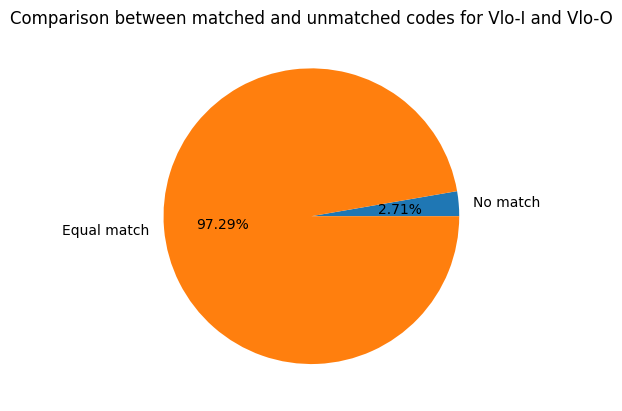

In [253]:
df_vlo = df[['Vlo-I', 'Vlo-O']]
# df_vlo = df_vlo.drop_duplicates()
df_vlo_unique = df_vlo[df_vlo['Vlo-I'] != df_vlo['Vlo-O']]
df_vlo_equal = df_vlo[df_vlo['Vlo-I'] == df_vlo['Vlo-O']]
unique_vlo = df_vlo_unique.count()
equal_vlo = df_vlo_equal.count()
print('Number of Unique values for flight number codes:\n{}\n\nNumber of equal values for flight number codes:\n{}'.format(unique_vlo, equal_vlo))

comp_vlo = [unique_vlo['Vlo-I'], equal_vlo['Vlo-I']]
plt.pie(comp_vlo, labels=['No match', 'Equal match'], autopct='%1.2f%%')
plt.title('Comparison between matched and unmatched codes for Vlo-I and Vlo-O')

From the above analysis, there are about 66356 equaled values among both the operation flight number and scheduled flight number and about 1850 samples (about 2% of dataset) of unequaled values.  We want to make sure that the operation flight matches the scheduled flight number.

Number of Unique values for destination codes:
Des-I    28
Des-O    28
dtype: int64

Number of equal values for destination codes:
Des-I    68178
Des-O    68178
dtype: int64


Text(0.5, 1.0, 'Comparison between matched and unmatched codes for Des-I and Des-O')

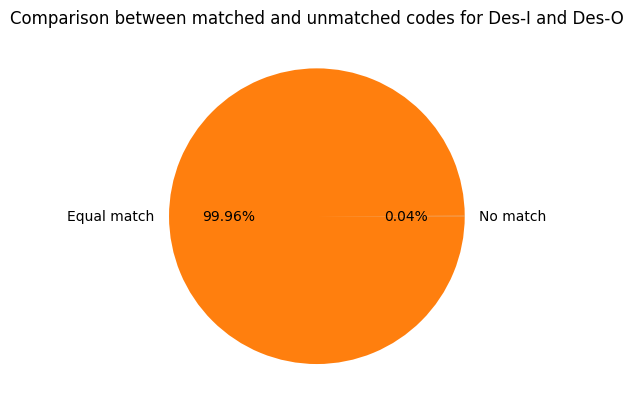

In [254]:
df_des = df[['Des-I', 'Des-O']]
# df_des = df_des.drop_duplicates()
df_des_unique = df_des[df_des['Des-I'] != df_des['Des-O']]
df_des_equal = df_des[df_des['Des-I'] == df_des['Des-O']]
unique_des = df_des_unique.count()
equal_des = df_des_equal.count()
print('Number of Unique values for destination codes:\n{}\n\nNumber of equal values for destination codes:\n{}'.format(unique_des, equal_des))

comp_des = [unique_des['Des-I'], equal_des['Des-I']]
plt.pie(comp_des, labels=['No match', 'Equal match'], autopct='%1.2f%%')
plt.title('Comparison between matched and unmatched codes for Des-I and Des-O')

The above analysis shows me that there are exactly 68206 Identical samples for the both the **Des-I** and **Des-O** data, and only 28 which shows me that this data might have been mislabelled which is about 0.04% of the overall data.  This can be changed during the data processing section.

Number of Unique values for airline codes:
Emp-I    18669
Emp-O    18669
dtype: int64

Number of equal values for airline codes: 
Emp-I    49537
Emp-O    49537
dtype: int64


Text(0.5, 1.0, 'Comparison between matched and unmatched codes for Emp-I and Emp-O')

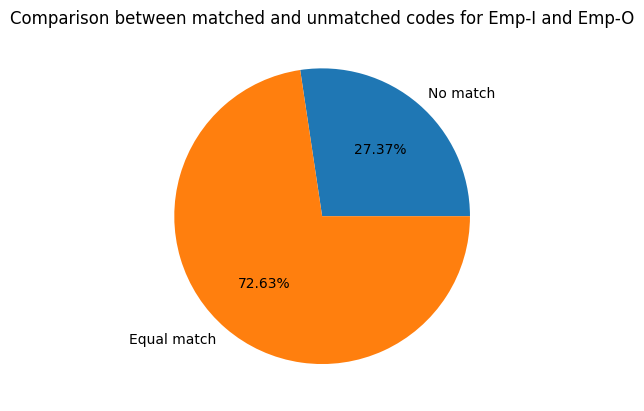

In [255]:
df_emp = df[['Emp-I', 'Emp-O']]
# df_emp = df_emp.drop_duplicates()
df_emp_unique = df_emp[df_emp['Emp-I'] != df_emp['Emp-O']]
df_emp_equal = df_emp[df_emp['Emp-I'] == df_emp['Emp-O']]
unique_emp = df_emp_unique.count()
equal_emp = df_emp_equal.count()
print('Number of Unique values for airline codes:\n{}\n\nNumber of equal values for airline codes: \n{}'.format(unique_emp, equal_emp))

comp_emp = [unique_emp['Emp-I'], equal_emp['Emp-I']]
plt.pie(comp_emp, labels=['No match', 'Equal match'], autopct='%1.2f%%')
plt.title('Comparison between matched and unmatched codes for Emp-I and Emp-O')

The above data shows me that the airline code of operated flight may not be correlate to the scheduled flight airline code.

Number of Unique values for Scheduled flight and operation flight:
Fecha-I    63417
Fecha-O    63417
dtype: int64

Number of values where there is no Operation flight: 
Fecha-I    4789
Fecha-O    4789
dtype: int64


Text(0.5, 1.0, 'Operational Scheduled Flights for 2017')

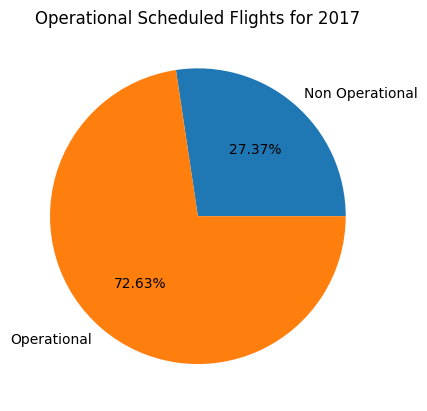

In [256]:
df_fecha = df[['Fecha-I', 'Fecha-O']]
# df_fecha = df_fecha.drop_duplicates()
df_fecha_unique = df_fecha[df_fecha['Fecha-I'] != df_fecha['Fecha-O']]
df_fecha_equal = df_fecha[df_fecha['Fecha-I'] == df_fecha['Fecha-O']]
unique_fecha = df_fecha_unique.count()
equal_fecha = df_fecha_equal.count()
print('Number of Unique values for Scheduled flight and operation flight:\n{}\n\nNumber of values where there is no Operation flight: \n{}'.format(unique_fecha, equal_fecha))

comp_fecha = [unique_fecha['Fecha-I'], equal_fecha['Fecha-I']]
plt.pie(comp_emp, labels=['Non Operational', 'Operational'], autopct='%1.2f%%')
plt.title('Operational Scheduled Flights for 2017')

The above shows me that there are exactly 4789 flights that did not operate as the scheduled flight time is the same as the operation time.

To finish up this section, I noticed that there are two unique values for the year column.  We are only interested in year 2017, I want to see how many values there are for the different year and what year it is.

In [257]:
df_date = df[df['AÑO']==2018]
df_date

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
66918,2017-12-31 23:55:00,602,SCEL,KLAX,LAN,2018-01-01 00:02:00,602.0,SCEL,KLAX,LAN,1,1,2018,Lunes,I,Grupo LATAM,Santiago,Los Angeles
66947,2017-12-31 23:40:00,622,SCEL,MMMX,LAN,2018-01-01 00:12:00,622.0,SCEL,MMMX,LAN,1,1,2018,Lunes,I,Grupo LATAM,Santiago,Ciudad de Mexico


These two samples are unique ones as the scheduled flight time was before the new year and the operation time went onto the next year.  So we can safely disregard any concern and keep this data as it still holds true for year 2017.

## Step 2: Exploratary Data Analysis for the Flight delay prediction

Now that I know what I am working with, I'd like to perform some exploratory data analysis to gain a better understanding of the independent variables in the dataset and their relationship.

I will start by analyzing the different arilines, since this is a LATAM Airline problem I would assume that we would only have one.

<AxesSubplot:xlabel='TIPOVUELO', ylabel='count'>

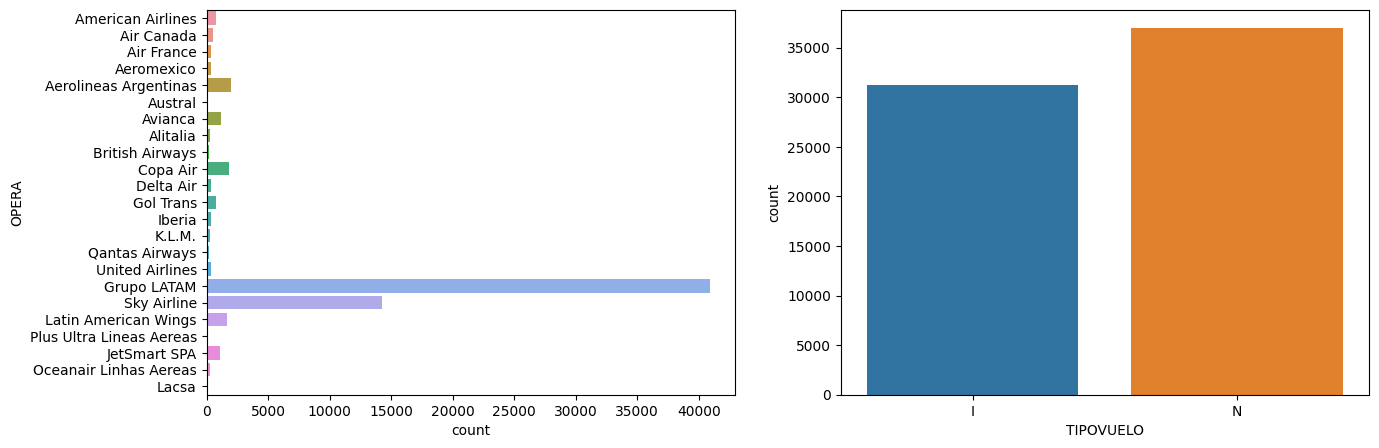

In [258]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(y='OPERA', data=df)
plt.subplot(1,2,2)
sns.countplot(x='TIPOVUELO', data=df)

Observing the number of airlines passing through the airport it's evident that LATAM airlines is the most frequenty visitor as expected since it is the largest airline in South America.  There are more national flights than International.

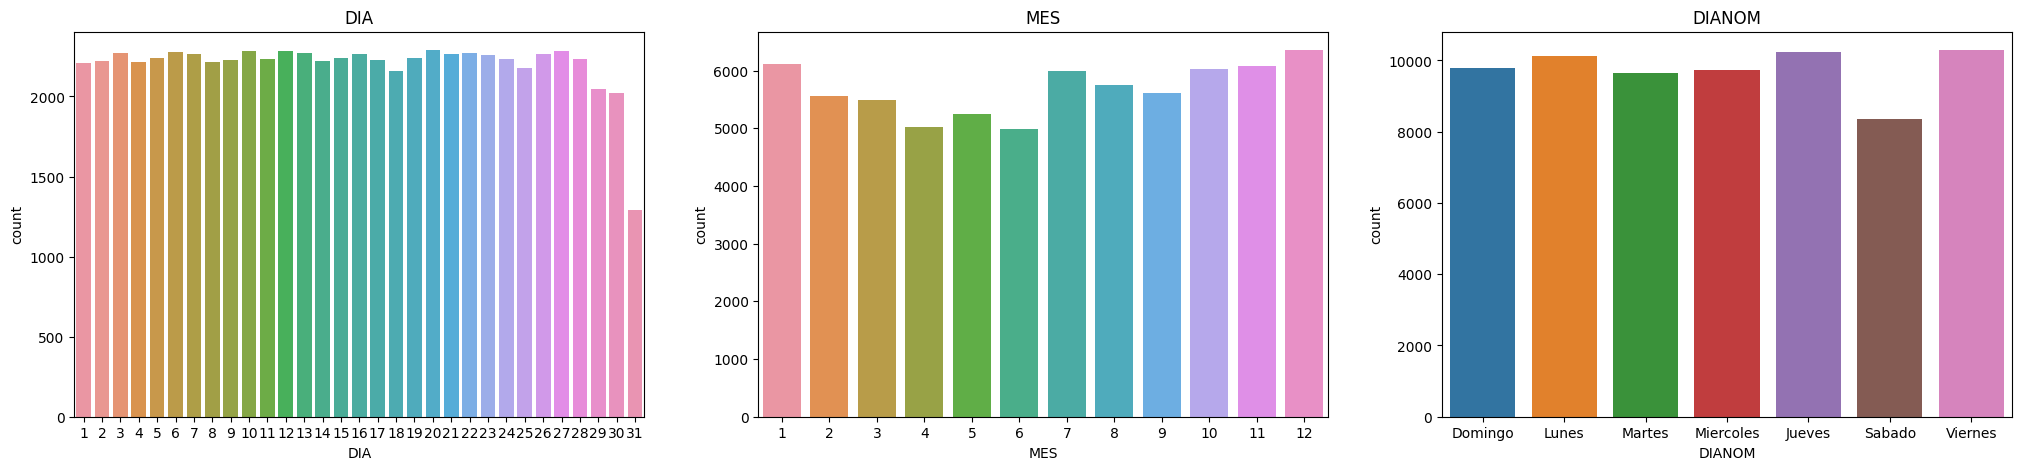

In [259]:
cols = ['DIA', 'MES', 'DIANOM']
plt.figure(figsize=(25,5))

for i, col in enumerate(cols):
    ax = plt.subplot(1, len(cols), i+1)
    sns.countplot(x=col, data=df)
    ax.set_title('{}'.format(col))


A few interesting observations can be made here:

1) The number of flights are consistent throughout the month, except when reaching near the end of the month the number of flight drops.
2) The frequency of flights drops between April and June.  The months with high flight frequency seems to be during January, July and October-December.
3) Saturdays tends to be days where travel isn't so frequent, which would make sense since normally when I search for flights Saturdays are always the most expensive.

<AxesSubplot:xlabel='count', ylabel='SIGLADES'>

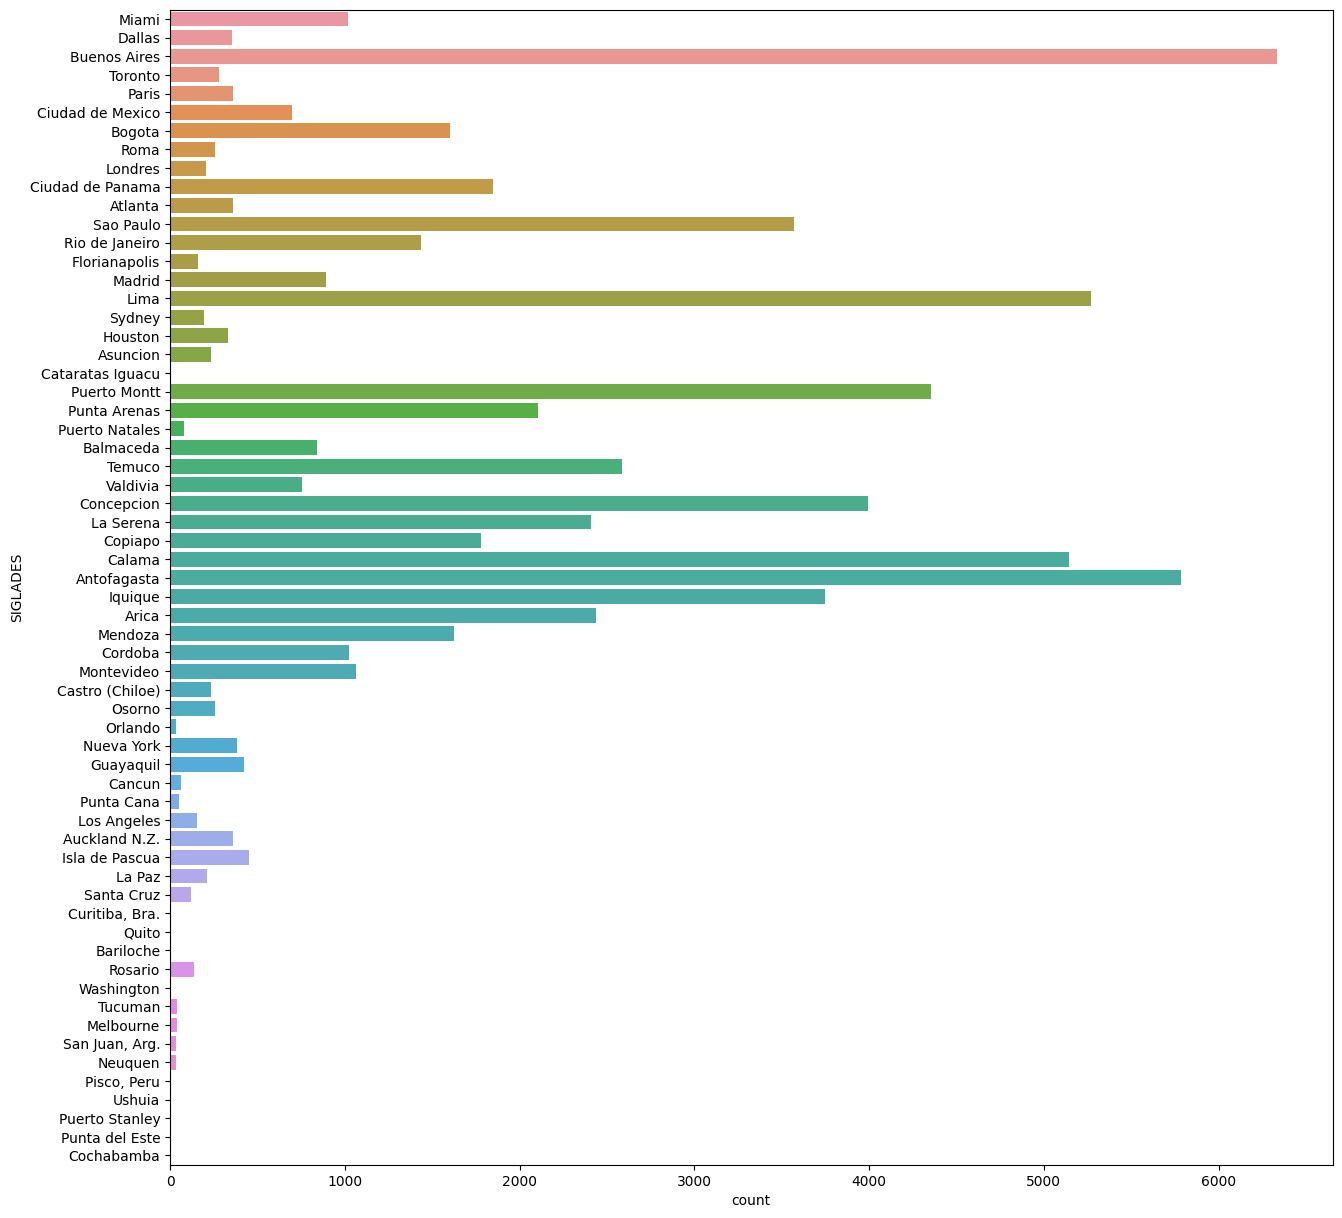

In [260]:
plt.figure(figsize=(15,15))
sns.countplot(y='SIGLADES', data=df)

Based on the different destinations and the type of flight (International or National) the data seems to match as the majority of city destinations are in Chile.

In [277]:
from geopy.geocoders import Nominatim

def get_coordinates(city):
    location = geolocator.geocode(city)
    return (location.latitude, location.longitude)

geolocator = Nominatim(user_agent="locate_city")

df_des = df['SIGLADES'][:5]

df_des = df_des.map(get_coordinates)

df_des

0    (25.7741728, -80.19362)
1    (25.7741728, -80.19362)
2    (25.7741728, -80.19362)
3    (25.7741728, -80.19362)
4    (25.7741728, -80.19362)
Name: SIGLADES, dtype: object

## Step 3: Pre processing Data for Delay prediction

This step will have the following data preprocessing to generate new data for delay prediction.  The dollowing new data are as follows:

1) **high_season**: If Fecha-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30 will have a value of 1 and 0 otherwise.
2) **min_diff**: Difference in minutes between Fecha-O and Fech-I.
3) **delay_15**: if min_diff > 15 then give value 1, else 0.
4) **period_day**: morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59), and night (between 19:00 and 4:59), based on Fecha-I.

These four steps all focus on the Fecha-I and Fecha-O, so I will begin with processing the Fecha-I samples.  A few things to consider when dealing with this data:

* It is a string in the format of 'yyyy-mm-dd hh:mm:ss'
* Time is 24-hour clock which makes it simple to understand and not having to convert from a 12 hour to a 24 hour clock.
* Only conversion that may be required is convert the 24 hour time to minutes or seconds as the seconds for quicker comparison between Fecha-I and Fecha-O.

In order to complete my data processing I have to create a few functions to manipulate the data and generate the synthetic data:

* `datetime_split`: splits the string data from fecha-I and Fecha-O to an array of integer and converts the 24 Hour time to seconds.
* `min_diff`: Calculates the time difference between Fecha-O and Fecha-I and converts it to minutes.
* `high_season`: I used a dictionary of lists as a lookup table to categories whether a flight flew during peak seasons.
* `delay_15`: If the time differance is greater than 15 minutes then it is considered as a delayed flight.
* `period_day`: I used another dictionary of lists as a lookup table for disinguishing if flight was scheduled for the morning, afternoon or night.

With this data, I then extracted the Fecha-I and Fecha-O data from the original dataframe and produced the desired synthetic features.

In [ ]:
def datetime_split(date_str):
    date_time = date_str.split()
    date_time = date_time[0].split('-') + date_time[1].split(':')
    date_time = [int(x) for x in date_time]
    time_s = [date_time[3]*3600 + date_time[4]*60 + date_time[5]]
    return date_time[:3] + time_s

def min_diff(time_i, time_o):
    time_diff = time_o - time_i
    return abs(time_diff/60)

def high_season(month, day):
    month_season = {'high': [1, 2], 
                    'low': [4, 5, 6, 8, 10, 11], 
                    'mid': {3: list(range(1,4)), 7: list(range(15,32)), 9: list(range(11,31)), 12: list(range(15,32))}}

    # Checks high and low months
    if month in month_season['high']:
        return 1
    elif month in month_season['low']:
        return 0

    # Checks if day of Month with temporary high/low seasons
    if day in month_season['mid'][month]:
        return 1
    else:
        return 0

def delay_15(time_diff):
    return 1 if time_diff>15 else 0

def period_day(time, sec_in_hour = 3600):
    period_of_day = {'morning': [5*sec_in_hour, 12*sec_in_hour],
                    'afternoon': [12*sec_in_hour, 19*sec_in_hour],
                    'night': [19*sec_in_hour, 5*sec_in_hour]}
    
    if time >= period_of_day['morning'][0] and time < period_of_day['morning'][1]:
        return 'morning'
    elif time >= period_of_day['afternoon'][0] and time < period_of_day['afternoon'][1]:
        return 'afternoon'
    elif time >= period_of_day['night'][0] or time < period_of_day['night'][1]:
        return 'night'

In [265]:
df_fecha_op = df[['Fecha-I', 'Fecha-O']]

df_fecha_arr = df_fecha_op.applymap(datetime_split)
df_fecha_arr['high_season'] = df_fecha_arr.apply(lambda x: high_season(month=x['Fecha-I'][1], day=x['Fecha-I'][2]), axis=1)
df_fecha_arr['min_diff'] = df_fecha_arr.apply(lambda x: min_diff(time_i=x['Fecha-I'][3], time_o=x['Fecha-O'][3]), axis=1)
df_fecha_arr['delay_15'] = df_fecha_arr.apply(lambda x: delay_15(x['min_diff']), axis=1)
df_fecha_arr['period_day'] = df_fecha_arr.apply(lambda x: period_day(x['Fecha-I'][3]), axis=1)

synthetic_features = df_fecha_arr[['min_diff', 'high_season', 'delay_15', 'period_day']]
synthetic_features.to_csv('../data/synthetic_features.csv', index=False)
synthetic_features.head()

,min_diff,high_season,delay_15,period_day
0,3.0,1,0,night
1,9.0,1,0,night
2,9.0,1,0,night
3,3.0,1,0,night
4,2.0,1,0,night


## Step 4: Data Analysis with synthetic features

Here I will explore the behaviour of the delay rate across destinations, airline, month of the year, day of the week, season, and type of flight.

In [267]:
df_syn = pd.read_csv('../data/synthetic_features.csv')

df_new = pd.concat([df, df_syn], axis=1)
df_new.head()


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,min_diff,high_season,delay_15,period_day
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,2017,Domingo,I,American Airlines,Santiago,Miami,3.0,1,0,night
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,2017,Lunes,I,American Airlines,Santiago,Miami,9.0,1,0,night
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,2017,Martes,I,American Airlines,Santiago,Miami,9.0,1,0,night
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,2017,Miercoles,I,American Airlines,Santiago,Miami,3.0,1,0,night
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,2017,Jueves,I,American Airlines,Santiago,Miami,2.0,1,0,night


Let's first observe the distribution of delays accross all flights.

<AxesSubplot:xlabel='delay_15', ylabel='count'>

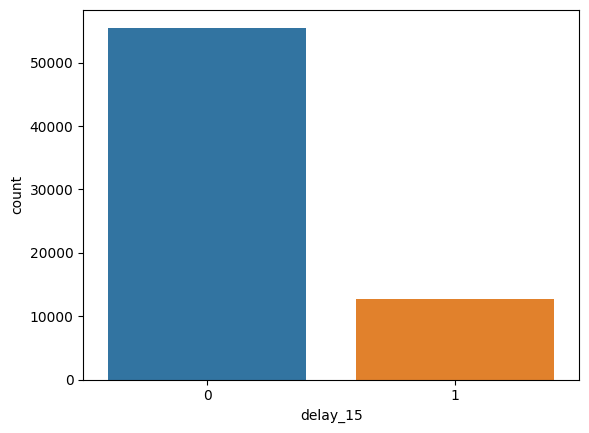

In [269]:
sns.countplot(x='delay_15', data=df_new)

The number of delayed flights are not plenty which is what every airport wants, because honestly... who enjoys delays?

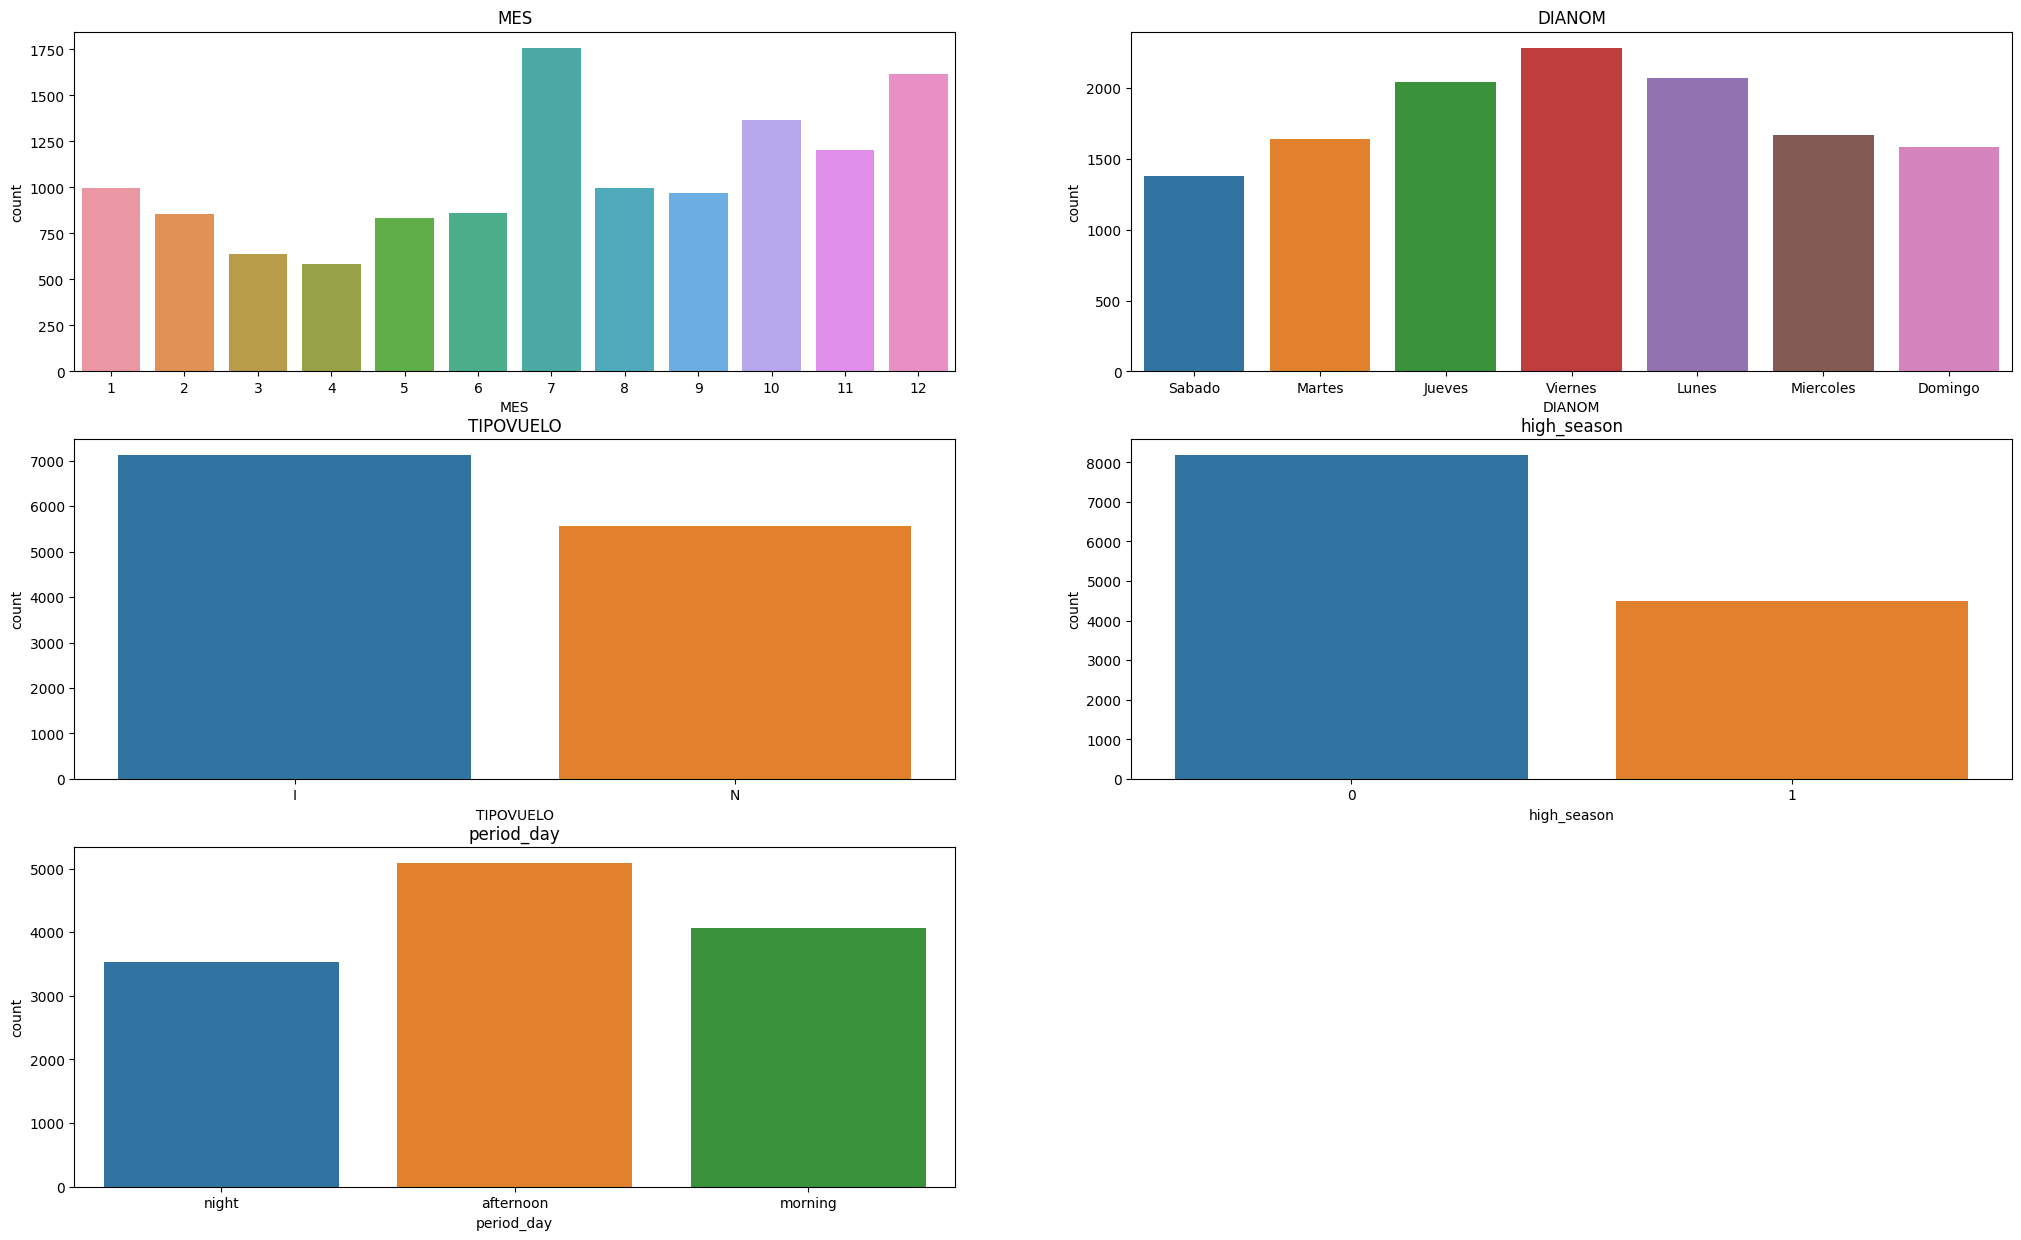

In [300]:
delay = df_new[['MES', 'DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLADES', 'high_season', 'period_day']][df_new['delay_15']==1]
day_month_period = ['MES', 'DIANOM', 'TIPOVUELO', 'high_season', 'period_day']
plt.figure(figsize=(25,15))

for i, col in enumerate(day_month_period):
    ax = plt.subplot(3, int(len(day_month_period)/2), i+1)
    sns.countplot(x=col, data=delay)
    ax.set_title('{}'.format(col))

Few observations to make here based on the delays:
* July and December are two months that experience a lot of delays, this could be because december is nearing the end of the year so people would love a vacation destination, and July and considering the climate change in Chile during that month it is cold so who wouldn't want to head somewhere warmer?
* Friday experiences the most delays, followed by Monday and Thursday, then Tuesday and Wednesday, and last Saturday and Sunday.  My theory is that travellers all shout T.G.I.F and the flight attendants just can't keep up with them.
* International flights experiences more delays then national/domestic flights.
* Beleive it or not but travelling during high season experiences less delays.
* The number of delays accros the different period of days are greater during the afternoon, then followed by the morning and at night.  If I consider myself in this situation, it would make sense because during afternoon it would coincide during work hours or rush hour so you'd expect travellers to show up late.  The morning, sometimes you don't hear your alarm and can cause delays for everyone.  Night is the best as you can find a ride to the airport easily and you're not rush.

<AxesSubplot:xlabel='count', ylabel='SIGLADES'>

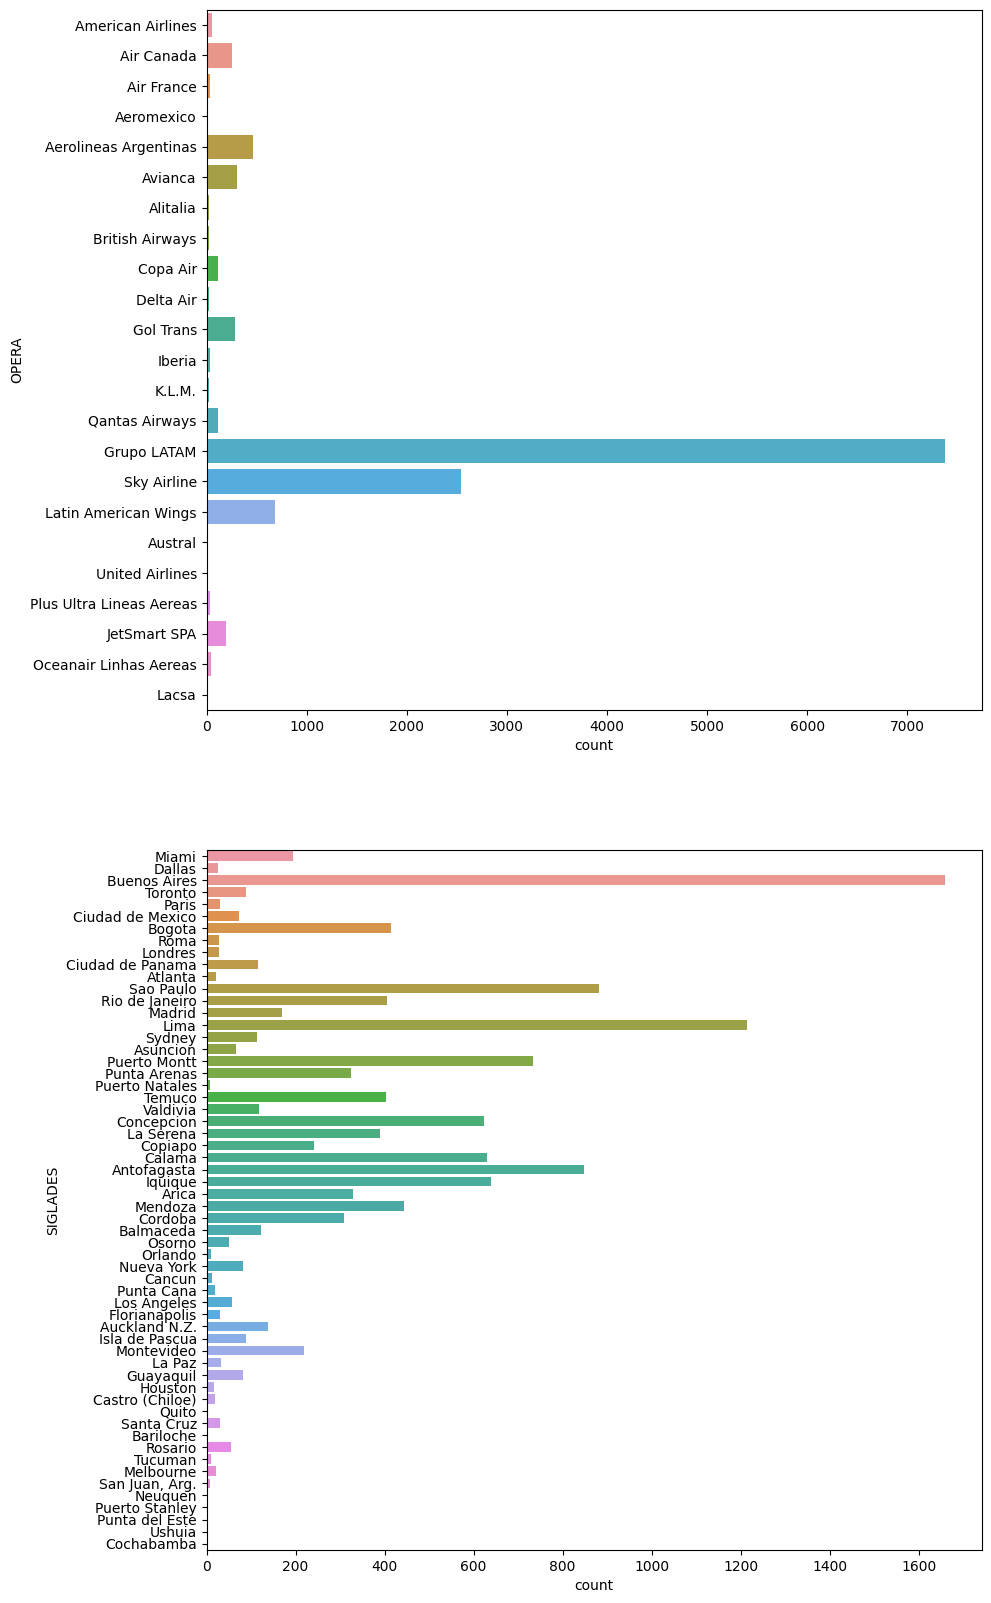

In [306]:
plt.figure(figsize=(10,20))
plt.subplot(2, 1, 1)
sns.countplot(y='OPERA', data=delay)
plt.subplot(2, 1, 2)
sns.countplot(y='SIGLADES', data=delay)

The delay relationship accross different airlines and destination are very unbalanced.  For example:
* The LATAM airline experiences the majority of delays.  As one of the largest South American airlines, it does operate more flights than other airlines in the continent.
* Some destinations experiences more delays than others, and this could be due various factors.  Nevertheless it is still an important factor to consider.

### Data Analysis conclusion:
Based on the above analysis, it may be important to consider the each data (month, day of week, destination, etc.).  However, the type of airline mey be reconsidered as the majority of delays fall under LATAM airline which could skew the training of a prediction model.  